# DineSafe Infraction Predictive Model

In [55]:
import warnings
warnings.simplefilter(action='ignore')
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, set_config
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression, SelectFromModel, SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from scipy.stats import loguniform
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report

In [2]:
ds = pd.read_csv('cleaned_data.csv', index_col=[0])

In [3]:
def transformations_pipe(df):
    # rename cols
    df = df.rename(columns={'ESTABLISHMENT_ID':'ID',
                           'ESTABLISHMENT_NAME':'NAME',
                           'ESTABLISHMENTTYPE':'TYPE',
                           'ESTABLISHMENT_ADDRESS':'ADDRESS',
                           'ESTABLISHMENT_STATUS':'STATUS',
                           'INSPECTION_DATE':'DATE',
                           'INFRACTION_DETAILS':'DEFICIENCY'})
    
    # fix datatypes
    df = df.astype({
        'ID': 'int32',
        'NAME':'str',
        'ADDRESS':'str',
        'DEFICIENCY':'str',
        'ACTION':'str',
        'SEVERITY':'str'
    })
    
    # dropping unused features
    df = df.drop([
        'COURT_OUTCOME',
        'AMOUNT_FINED',
        'INSPECTION_ID'
    ], axis=1)
    
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

    return df

def fix_names(df, cols):
    # based on cols specified, remove the punctuation and make lower
    punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'   # `|` is not present here
    transtab = str.maketrans(dict.fromkeys(punct, ''))
    for col in cols:
        df[col] = '|'.join(df[col].tolist()).translate(transtab).split('|')
        df[col] = df[col].str.lower()
          
    return df

In [4]:
ds = transformations_pipe(ds)
fix_names(ds, [
     'NAME',
     'TYPE',
     'ADDRESS',
     'DEFICIENCY',
     'SEVERITY',
     'ACTION',
])

,ID,NAME,TYPE,ADDRESS,LATITUDE,LONGITUDE,STATUS,MINIMUM_INSPECTIONS_PERYEAR,DEFICIENCY,DATE,SEVERITY,ACTION,RATE_OF_INFRACTION(from_name)
ROW_ID,,,,,,,,,,,,,
1,1222579,sailila khaman dhokla house,food take out,870 markham rd,43.767980,-79.229029,Pass,3.0,nan,2003-04-25,nan,nan,0.859467
2,1222579,sailila khaman dhokla house,food take out,870 markham rd,43.767980,-79.229029,Conditional Pass,3.0,operator fail to clean washroom fixtures,2003-10-23,s significant,notice to comply,0.859467
3,1222579,sailila khaman dhokla house,food take out,870 markham rd,43.767980,-79.229029,Conditional Pass,3.0,operator fail to properly maintain equipment,2003-10-23,s significant,notice to comply,0.859467
4,1222579,sailila khaman dhokla house,food take out,870 markham rd,43.767980,-79.229029,Conditional Pass,3.0,operator fail to properly maintain rooms,2003-10-23,m minor,notice to comply,0.859467
5,1222579,sailila khaman dhokla house,food take out,870 markham rd,43.767980,-79.229029,Conditional Pass,3.0,operator fail to properly wash equipment,2003-10-23,m minor,notice to comply,0.859467
...,...,...,...,...,...,...,...,...,...,...,...,...,...
733491,10765712,s and a variety store,food store conveniencevariety,128 pritchard ave,43.669737,-79.492723,Pass,3.0,nan,2022-10-07,nan,nan,0.715226
733492,10765721,fullaluv express,food take out,1707 jane st,43.703845,-79.503785,Pass,3.0,nan,2022-10-07,nan,nan,0.765896
733493,10765722,xinlong food,food take out,1571 sandhurst crcl,43.809229,-79.269315,Pass,2.0,fail to ensure completion of food handling tra...,2022-10-07,na not applicable,notice to comply,0.762376


### Create list of chains based on dataset

In [5]:
ds['Year'] = ds['DATE'].dt.year
chain_list = (ds.groupby(['Year', 'NAME']) # group by year and restaurant name
              .agg(counts = ('ID', 'nunique')) # count by chain 
              .sort_values(['Year', 'counts'], ascending=[False, False])
              .reset_index())
chain_list = chain_list[chain_list['counts']>2] # chains are where there are three or more locations

In [6]:
def chain_feature(df, chains):
    df['chain'] = 0
    df.loc[df['NAME'].isin(chains['NAME']), ['chain']] = 1
    df.loc[~(df['NAME'].isin(chains['NAME'])), ['chain']] = 0
    
    return df

In [7]:
chain_feature(ds, chain_list)

,ID,NAME,TYPE,ADDRESS,LATITUDE,LONGITUDE,STATUS,MINIMUM_INSPECTIONS_PERYEAR,DEFICIENCY,DATE,SEVERITY,ACTION,RATE_OF_INFRACTION(from_name),Year,chain
ROW_ID,,,,,,,,,,,,,,,
1,1222579,sailila khaman dhokla house,food take out,870 markham rd,43.767980,-79.229029,Pass,3.0,nan,2003-04-25,nan,nan,0.859467,2003,0
2,1222579,sailila khaman dhokla house,food take out,870 markham rd,43.767980,-79.229029,Conditional Pass,3.0,operator fail to clean washroom fixtures,2003-10-23,s significant,notice to comply,0.859467,2003,0
3,1222579,sailila khaman dhokla house,food take out,870 markham rd,43.767980,-79.229029,Conditional Pass,3.0,operator fail to properly maintain equipment,2003-10-23,s significant,notice to comply,0.859467,2003,0
4,1222579,sailila khaman dhokla house,food take out,870 markham rd,43.767980,-79.229029,Conditional Pass,3.0,operator fail to properly maintain rooms,2003-10-23,m minor,notice to comply,0.859467,2003,0
5,1222579,sailila khaman dhokla house,food take out,870 markham rd,43.767980,-79.229029,Conditional Pass,3.0,operator fail to properly wash equipment,2003-10-23,m minor,notice to comply,0.859467,2003,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733491,10765712,s and a variety store,food store conveniencevariety,128 pritchard ave,43.669737,-79.492723,Pass,3.0,nan,2022-10-07,nan,nan,0.715226,2022,0
733492,10765721,fullaluv express,food take out,1707 jane st,43.703845,-79.503785,Pass,3.0,nan,2022-10-07,nan,nan,0.765896,2022,0
733493,10765722,xinlong food,food take out,1571 sandhurst crcl,43.809229,-79.269315,Pass,2.0,fail to ensure completion of food handling tra...,2022-10-07,na not applicable,notice to comply,0.762376,2022,0


### Adding Census Tract as feature

In [8]:
# Load Toronto CMA boundaries shapefile
boundaries = gpd.read_file('lct_000b16a_e.shp')
toronto_boundaries = boundaries[boundaries['CMANAME'] == 'Toronto']
toronto_boundaries = toronto_boundaries[['CTUID', 'CTNAME', 'geometry']]
toronto_boundaries['CTUID'] = toronto_boundaries['CTUID'].astype(float)
# Load census income data
income_data = pd.read_csv('income_data.csv')
income_data = income_data.rename(columns={'COL0':'CTUID', 'COL1':'Census Tract name', 'COL2':'Average Total Income 2015'})
income_data['CTUID'] = income_data['CTUID'].astype(float)
# Join neighbourhood and income data
neighbourhood_income = pd.merge(toronto_boundaries, income_data, on='CTUID', how='outer')
neighbourhood_income['CTUID'] = neighbourhood_income['CTUID'].astype(str)

In [9]:
geometry = gpd.points_from_xy(ds.LONGITUDE, ds.LATITUDE)
gdf = gpd.GeoDataFrame(ds, geometry=geometry)
ds_gdf = gpd.sjoin(neighbourhood_income.to_crs(epsg=4326), gdf, how='inner', op='intersects')
ds_gdf['Inspections'] = 1
ds_gdf['Infractions'] = ~ds_gdf['SEVERITY'].isnull()
ds_gdf['Infractions'] = ds_gdf['Infractions'].astype(int)
ds = pd.DataFrame(ds_gdf)

In [10]:
ds = ds.drop(['geometry', 'index_right'], axis=1)

In [11]:
ds.columns

Index(['CTUID', 'CTNAME', 'Census Tract name', 'Average Total Income 2015',
       'ID', 'NAME', 'TYPE', 'ADDRESS', 'LATITUDE', 'LONGITUDE', 'STATUS',
       'MINIMUM_INSPECTIONS_PERYEAR', 'DEFICIENCY', 'DATE', 'SEVERITY',
       'ACTION', 'RATE_OF_INFRACTION(from_name)', 'Year', 'chain',
       'Inspections', 'Infractions'],
      dtype='object')

In [13]:
ds['pass']=0
ds.loc[ds['DEFICIENCY']=='nan', 'pass']=1
ds.loc[~(ds['DEFICIENCY']=='nan'), 'pass']=0

In [15]:
ds['Average Total Income 2015'] = ds['Average Total Income 2015'].fillna(ds['Average Total Income 2015'].mean())

In [16]:
ds['RATE_OF_INFRACTION(from_name)'] = ds['RATE_OF_INFRACTION(from_name)'].fillna(ds['RATE_OF_INFRACTION(from_name)'].mean())

In [17]:
ds['MINIMUM_INSPECTIONS_PERYEAR'] = ds['MINIMUM_INSPECTIONS_PERYEAR'].fillna(3)

## Model

In [71]:
y=ds['pass']
X=ds.drop('pass',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=12345)

In [82]:
num_features = [
    'RATE_OF_INFRACTION(from_name)',
    'Average Total Income 2015'
]
num_transform = Pipeline(steps=[('poly',PolynomialFeatures(degree = 2)),
                                      ('scaler', MinMaxScaler())])

cat_features = ['chain',
                'TYPE',
#                 'STATUS',
                'CTUID',
                'MINIMUM_INSPECTIONS_PERYEAR',
#                 'SEVERITY',
                'Year'
]

cat_transform = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

skb = SelectKBest(
    chi2,
    k=568)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transform, num_features),
        ('cat', cat_transform, cat_features)])

# forest = RandomForestClassifier(random_state=12345)

# smt = SMOTE(random_state=12345)
lor = LogisticRegression(C=0.615848211066026, max_iter=1000, penalty='none')
clf = Pipeline(
    [('preprocessor', preprocessor),
    ('skb', skb),
#     ('smt', smt), 
# I disabled SMOTE because it's quite laggy     
    ('lor',lor)]
)

In [83]:
%%time
clf.fit(X_train, y_train).fit(X_train, y_train)

CPU times: total: 29.7 s
Wall time: 29.7 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['RATE_OF_INFRACTION(from_name)',
                                                   'Average Total Income '
                                                   '2015']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['chain', 'TYPE', 'CTUID',
                                                   'MINIMUM_INSPECTIONS_PERYEAR',
                                                   'Year'])])),
                ('skb',
                 SelectKBest(k=568,
                             score_func=<function chi2 at 0x0000014771410AF0>)),
                ('lor',
                 LogisticRegression(C=0.615848211066026, max_iter=1000,
                                    penalty='none'))])

In [84]:
f1_score(clf.predict(X_train), y_train)

0.4674444289286938

# Test

In [85]:
f1_score(clf.predict(X_test), y_test)

0.46658394578600737

              precision    recall  f1-score   support

           0       0.71      0.88      0.79    349655
           1       0.64      0.37      0.47    200104

    accuracy                           0.69    549759
   macro avg       0.67      0.62      0.63    549759
weighted avg       0.68      0.69      0.67    549759

f_score = 0.4674444289286938


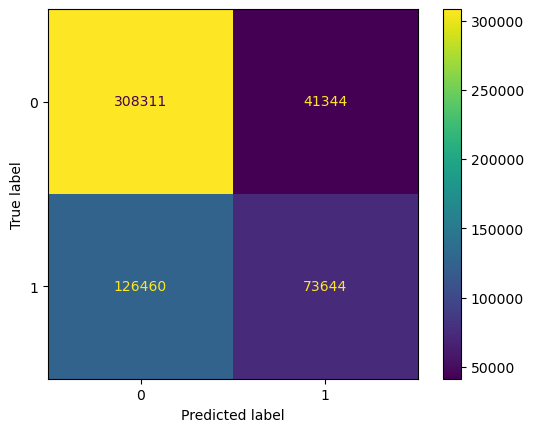

In [86]:
print(classification_report(y_train, clf.predict(X_train)))
plot_confusion_matrix(clf,X_train,y_train)
print(f'f_score = {f1_score(y_train, clf.predict(X_train))}')

# Hyper parameter tuning
### Warning: Very Slow...

In [66]:
param_grid = [   
    {
    'skb__k' : np.arange(10, 660, 2),
    }
]

In [77]:
param_grid = [   
    {
    'lor__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'lor__C' : np.logspace(-4, 4, 20),
    'lor__solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'lor__max_iter' : [100, 1000,2500, 5000]
    }
]

In [78]:
clf2 = RandomizedSearchCV(clf, param_distributions = param_grid, scoring='f1', n_iter=10, verbose=True)

In [79]:
%%time
best_clf = clf2.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 41min 36s
Wall time: 41min 36s


In [80]:
best_clf.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['chain',
                                                   'RATE_OF_INFRACTION(from_name)',
                                                   'Average Total Income '
                                                   '2015']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TYPE', 'CTUID',
                                                   'MINIMUM_INSPECTIONS_PERYEAR',
                                                   'Year'])])),
                ('skb',
                 SelectKBest(k=568,
                             score_func=<function chi2 at 0x0000014771410AF0>)),
                ('lor',
                 LogisticRegression(C=0.615848211066026, max_iter=1000,
                                    penalty='none'))])

In [81]:
best_clf.best_score_

0.4671506872775442